# Thinking & Action

## Thinking1:常用的文本分类方法都有哪些

- 传统机器学习方法
1. 朴素贝叶斯模型(Naive Bayes Model，NB)
2. 随机森林模型（RF）
3. SVM分类模型
4. KNN分类模型
5. GBDT/XGBOOST
- 深度学习方法
1. TextCNN(包括LSTM、GRU)
2. FastText
3. TextRNN
4. RCNN
5. HAN
6. DPCNN
7. Densely Connected CNN
8. GNN：TextGCN
9.  Capsule Networks
10. Semi-supervised Text Classification
11. Transformable Convolutional Neural Network

## Thinking2：RNN为什么会出现梯度消失

#### 由公式可以看出 $ tanh^` <= 1$，对于训练过程大部分情况下tanh的导数是小于1的，因为很少情况下会出现$W_i + W_sS_{j-1} + b_1 =0$，如果 $ W_s $也是一个大于0小于1的值，则当t很大时$ \prod_{j = k + 1}^t tanh`W_s $，就会趋近于0，就会出现梯度消失现象

##  Action：cnews 中文文本分类

In [37]:
import numpy as np
import torch
from torch import nn
from torch import optim
import tensorflow as tf 
import torch.utils.data as Data
from torch.nn import init
from model import TextRNN
from cnews_loader import read_category,read_vocab,process_file
import matplotlib.pyplot as  plt
from tensorboard_logger import Logger
logger = Logger(logdir="./tensorboard_logs", flush_secs=10)

In [38]:
# 超参数定义
BATCH_SIZE = 100
EPOCH = 30
LR = 0.001

In [39]:
# 数据加载及分批
categories, cat_to_id = read_category()  # 获取文本的类别及其对应id的字典
words, word_to_id = read_vocab('cnews.vocab.txt')  # 获取训练文本中所有出现过的字及其所对应的id
vocab_size = len(words)  # 获取字数
VOCAB_SIZE = vocab_size
x_train, y_train = process_file('cnews.train.txt', word_to_id, cat_to_id, 600)  # 获取训练数据每个字的id和对应标签的one-hot形式
x_val, y_val = process_file('cnews.val.txt', word_to_id, cat_to_id, 600)

In [40]:
# 转化为 tensor 的形式
x_train,y_train = torch.LongTensor(x_train),torch.LongTensor(y_train)
x_val,y_val = torch.LongTensor(x_val),torch.LongTensor(y_val)

# 设置数据分批训练
train_dataset = Data.TensorDataset(x_train,y_train)
train_loader = Data.DataLoader(dataset = train_dataset,batch_size = BATCH_SIZE,shuffle = True)
val_dataset = Data.TensorDataset(x_val,y_val)
val_loader = Data.DataLoader(dataset = val_dataset,batch_size = BATCH_SIZE,shuffle = True)

In [41]:
# 设置初始化方式
def weights_init_kaiming(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_out')
        init.constant_(m.bias.data, 0.0)

In [42]:
# 记录精确度
accuracy = []
val_accuracy = []
# 使用TextRNN
model = TextRNN().cuda()
model.apply(weights_init_kaiming)  # 初始化网络

TextRNN(
  (embedding): Embedding(5000, 64)
  (rnn): GRU(64, 128, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [43]:
def train():

    # 定义多分类的损失函数
    optimizer = optim.Adam(model.parameters(), lr=LR)
    Loss = nn.MultiLabelMarginLoss()
    best_val_acc = 0  # 设定初始当前最好的精度为 0
    rnn = TextRNN().cuda()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
    loss_func = nn.MultiLabelSoftMarginLoss()
    

    for epoch in range(EPOCH):
        for step, (b_x, b_y) in enumerate(train_loader):

            b_x,b_y = b_x.cuda(),b_y.cuda()
            output = rnn(b_x)
            loss = loss_func(output, b_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            accuracy_ = np.mean((torch.argmax(output, 1) == torch.argmax(b_y, 1)).cpu().numpy())
#             writer1.add_scalar(accuracy,accuracy_, global_step=step, walltime=None)
            # 记录所需的变量
            logger.log_value('loss', loss.item(), epoch*len(train_loader) + step)
            logger.log_value('accuracy', accuracy_, epoch*len(train_loader) + step)
            
            
            print(f'|训练 epoch:{epoch},step:{step}:accuracy:{accuracy_:5f}')
            if (step + 1) % 25 == 0:
                accuracy.append(accuracy_)
                val_accuracy_temp = []  # 用来记录每次验证的平均准确度
                for s, (val_x, val_y) in enumerate(val_loader):
                    val_x,val_y = val_x.cuda(),val_y.cuda()
                    val_out = rnn(val_x)

                    val_accuracy_temp.append(np.mean((torch.argmax(val_out, 1) == torch.argmax(val_y, 1)).cpu().numpy()))
                    if val_accuracy_temp[-1] > best_val_acc:
                        torch.save(rnn.state_dict(), 'week4_rnn.pkl')
                        best_val_acc = val_accuracy_temp[-1]
                val_accuracy.append(np.mean(val_accuracy_temp))
                print(f'|验证 accuracy:{accuracy[-1]:.5f},val_accuracy:{val_accuracy[-1]:.5f}')



In [44]:
# 设置随机数种子
torch.manual_seed(33)
train()

|训练 epoch:0,step:0:accuracy:0.060000
|训练 epoch:0,step:1:accuracy:0.140000
|训练 epoch:0,step:2:accuracy:0.170000
|训练 epoch:0,step:3:accuracy:0.340000
|训练 epoch:0,step:4:accuracy:0.260000
|训练 epoch:0,step:5:accuracy:0.200000
|训练 epoch:0,step:6:accuracy:0.290000
|训练 epoch:0,step:7:accuracy:0.230000
|训练 epoch:0,step:8:accuracy:0.300000
|训练 epoch:0,step:9:accuracy:0.310000
|训练 epoch:0,step:10:accuracy:0.360000
|训练 epoch:0,step:11:accuracy:0.430000
|训练 epoch:0,step:12:accuracy:0.420000
|训练 epoch:0,step:13:accuracy:0.320000
|训练 epoch:0,step:14:accuracy:0.340000
|训练 epoch:0,step:15:accuracy:0.280000
|训练 epoch:0,step:16:accuracy:0.300000
|训练 epoch:0,step:17:accuracy:0.360000
|训练 epoch:0,step:18:accuracy:0.260000
|训练 epoch:0,step:19:accuracy:0.250000
|训练 epoch:0,step:20:accuracy:0.300000
|训练 epoch:0,step:21:accuracy:0.320000
|训练 epoch:0,step:22:accuracy:0.400000
|训练 epoch:0,step:23:accuracy:0.220000
|训练 epoch:0,step:24:accuracy:0.350000
|验证 accuracy:0.35000,val_accuracy:0.30340
|训练 epoch:0,step:2

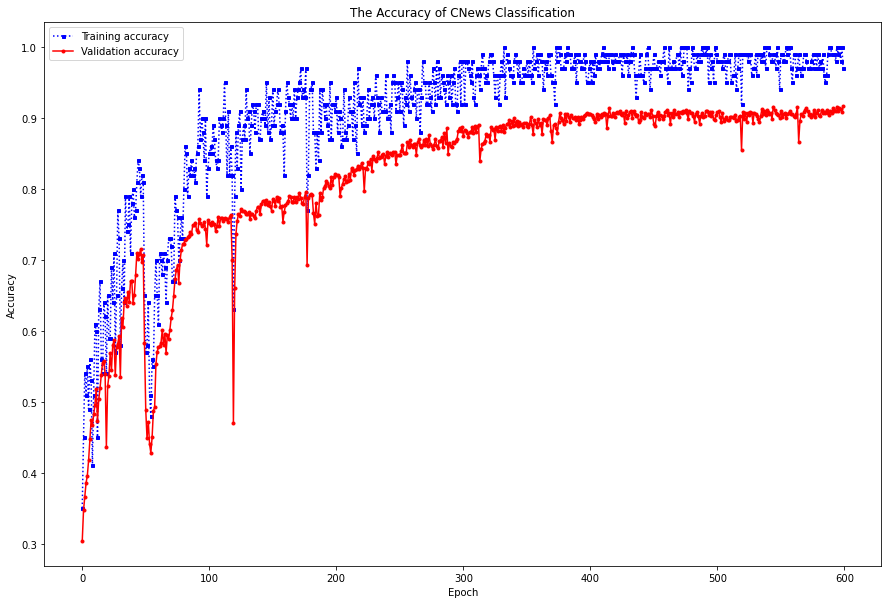

In [32]:
plt.figure(figsize=(15,10))
# 绘制准确度曲线
counter = list(range(len(accuracy)))
plt.plot(counter,accuracy,marker = 's',linestyle = ':',color='b', label="Training accuracy",ms = 3)
plt.plot(counter,val_accuracy,marker = 'o',linestyle = '-',color='r', label="Validation accuracy",ms = 3)
plt.xlabel("Epoch")
plt.ylabel('Accuracy')
plt.title('The Accuracy of CNews Classification')
plt.legend(loc = 'best')
plt.savefig('rnn_model.jpg')

In [33]:
# 测试模型
import keras as kr
vocab_file = 'cnews.vocab.txt'
class RnnModel:
    def __init__(self):
        self.categories, self.cat_to_id = read_category()
        self.words, self.word_to_id = read_vocab(vocab_file)
        self.model = TextRNN()
        self.model.load_state_dict(torch.load('week4_rnn.pkl'))
 
    def predict(self, message):
        content = message
        data = [self.word_to_id[x] for x in content if x in self.word_to_id]
        data = kr.preprocessing.sequence.pad_sequences([data], 600)
        data = torch.LongTensor(data)
        y_pred_cls = self.model(data)
        class_index = torch.argmax(y_pred_cls[0]).item()
        return self.categories[class_index]
 
 
if __name__ == '__main__':
    model = RnnModel()
    test_demo = ['《时光重返四十二难》恶搞唐增取经一款时下最热门的动画人物：猪猪侠，加上创新的故事背景，震撼的操作快感，成就了这部恶搞新作，现正恶搞上市，玩家们抢先赶快体验快感吧。游戏简介：被时光隧道传送到208年的猪猪侠，必须经历六七四十二难的考验，才能借助柯伊诺尔大钻石的力量，开启时光隧道，重返2008年。在迷糊老师、菲菲公主的帮助下，猪猪侠接受了挑战，开始了这段充满了关心和情谊的旅程。    更多精彩震撼感觉，立即下载该款游戏尽情体验吧。玩家交流才是王道，讯易游戏玩家交流中心 QQ群：6306852-----------------生活要有激情，游戏要玩多彩(多彩游戏)。Colourfulgame (多彩游戏)，让你看看快乐游戏的颜色！精品推荐：1：《钟馗传》大战无头关羽，悲壮的剧情伴随各朝英灵反攻地府！2：《中华群英》将和赵云，项羽，岳飞等猛将作战，穿越各朝代抗击日寇。良品推荐：1：《赌王争霸之斗地主》易飞会在四角恋中会选择谁？是否最终成赌神呢？2：勇者后裔和魔王紧缠一起，前代恩怨《圣火伏魔录》将为您揭示一切。  3：颠覆传统概念，恶搞+非主流？！誓必弄死搞残为止《爆笑飞行棋》。4：《中国象棋残局大师》快棋和人机模式让畅快对弈！一切“多彩游戏”资讯，点击Colourfulgame官网http://www.colourfulgame.com一切“多彩游戏”感言，交流Colourfulgame论坛http://121.33.203.124/forum/【客服邮箱】：xunyiwangluo@126.com">xunyiwangluo@126.com">xunyiwangluo@126.com【客服热线】：020-87588437']
                 
    for i in test_demo:
        print(i,"\n\n预测结果:",model.predict(i))

《时光重返四十二难》恶搞唐增取经一款时下最热门的动画人物：猪猪侠，加上创新的故事背景，震撼的操作快感，成就了这部恶搞新作，现正恶搞上市，玩家们抢先赶快体验快感吧。游戏简介：被时光隧道传送到208年的猪猪侠，必须经历六七四十二难的考验，才能借助柯伊诺尔大钻石的力量，开启时光隧道，重返2008年。在迷糊老师、菲菲公主的帮助下，猪猪侠接受了挑战，开始了这段充满了关心和情谊的旅程。    更多精彩震撼感觉，立即下载该款游戏尽情体验吧。玩家交流才是王道，讯易游戏玩家交流中心 QQ群：6306852-----------------生活要有激情，游戏要玩多彩(多彩游戏)。Colourfulgame (多彩游戏)，让你看看快乐游戏的颜色！精品推荐：1：《钟馗传》大战无头关羽，悲壮的剧情伴随各朝英灵反攻地府！2：《中华群英》将和赵云，项羽，岳飞等猛将作战，穿越各朝代抗击日寇。良品推荐：1：《赌王争霸之斗地主》易飞会在四角恋中会选择谁？是否最终成赌神呢？2：勇者后裔和魔王紧缠一起，前代恩怨《圣火伏魔录》将为您揭示一切。  3：颠覆传统概念，恶搞+非主流？！誓必弄死搞残为止《爆笑飞行棋》。4：《中国象棋残局大师》快棋和人机模式让畅快对弈！一切“多彩游戏”资讯，点击Colourfulgame官网http://www.colourfulgame.com一切“多彩游戏”感言，交流Colourfulgame论坛http://121.33.203.124/forum/【客服邮箱】：xunyiwangluo@126.com">xunyiwangluo@126.com">xunyiwangluo@126.com【客服热线】：020-87588437 

预测结果: 游戏
